In [2]:
# Install if running for the first time 
# !pip install git+https://github.com/pmbaumgartner/setfit -q

### Importing Necessary Libraries

In [34]:
# Data Manipulation
import pandas as pd

# ML Model
from setfit import SetFitClassifier

# Evaluation and Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Loading Dataset

In [2]:
raw_train_df = pd.read_csv('./data/train.tsv', sep='\t')
raw_test_df = pd.read_csv('./data/test.tsv', sep='\t')

train_df = raw_train_df.copy()
test_df = raw_test_df.copy()

In [3]:
train_df.sample(5, random_state=42)   

,PhraseId,SentenceId,Phrase,Sentiment
95722,95723,5000,'s as sorry,2
147312,147313,8016,Romantic comedy and Dogme 95 filmmaking may se...,4
36991,36992,1752,of these days,2
150211,150212,8182,flinch from its unsettling prognosis,2
140655,140656,7631,are clinically depressed,1


In [4]:
test_df.sample(5, random_state=42)   

,PhraseId,SentenceId,Phrase
43654,199715,10623,tempting to jump ship in January to avoid ridi...
48255,204316,10864,terrific and
13645,169706,9123,for decades
40638,196699,10461,to its not-so-stock characters
10925,166986,8995,one of the best films of the year


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


We can see there are no missing values. That means preprocessing was already done from before. 

Data Dictionary

In [7]:
train_df['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

We can see there are 5 different sentiment labels. Lets what each of them apply and then we will accordingly assign them text labels. 

In [8]:
train_df[train_df['Sentiment'] == 0].sample(3, random_state=42)

,PhraseId,SentenceId,Phrase,Sentiment
115485,115486,6153,"It 's hard to imagine any recent film , indepe...",0
72448,72449,3702,as a numbingly dull experience,0
101189,101190,5318,by its predictable plot and paper-thin support...,0


In [9]:
train_df[train_df['Sentiment'] == 1].sample(3, random_state=42)

,PhraseId,SentenceId,Phrase,Sentiment
25753,25754,1177,Where the film falters is in its tone .,1
77268,77269,3975,rag-tag bunch,1
55455,55456,2768,"It wo n't harm anyone , but",1


In [10]:
train_df[train_df['Sentiment'] == 2].sample(3, random_state=42)

,PhraseId,SentenceId,Phrase,Sentiment
67248,67249,3412,seem pretty unbelievable at times,2
85134,85135,4403,"smitten document of a troubadour , his acolyte...",2
49560,49561,2427,the 1984 uncut version of Sergio Leone,2


In [11]:
train_df[train_df['Sentiment'] == 3].sample(3, random_state=42)

,PhraseId,SentenceId,Phrase,Sentiment
61156,61157,3090,a consummate actor incapable of being boring,3
69544,69545,3535,Mr. Spielberg and his company just want you to...,3
54416,54417,2704,"really , really good things can come in enormo...",3


In [12]:
train_df[train_df['Sentiment'] == 4].sample(3, random_state=42)

,PhraseId,SentenceId,Phrase,Sentiment
4821,4822,184,", uplifting and moving",4
73463,73464,3754,"an emotionally accessible , almost mystical work",4
41865,41866,2015,who are capable of anteing up some movie star ...,4


As per the above samples, we will assign following text labels to each of the 5 sentiment labels.

In [13]:
text_labels = {
    0: 'Very_Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Very_Positive'
}

In [14]:
train_df['Sentiment_full'] = train_df['Sentiment'].map(text_labels)

In [15]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_full
0,1,1,A series of escapades demonstrating the adage ...,1,Negative
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral
2,3,1,A series,2,Neutral
3,4,1,A,2,Neutral
4,5,1,series,2,Neutral


In [19]:
train_pos_neg = train_df[(train_df['Sentiment_full'] == 'Very_Negative') | (train_df['Sentiment_full'] == 'Very_Positive')]

In [20]:
train_pos_neg.shape

(16278, 5)

For our exercise, we will train only very positive and very negative sentiment data with just few examples as that is the main purpose.

In [22]:
train_100 = train_pos_neg.sample(100, random_state=42)

In [23]:
val_100 = train_pos_neg.sample(50, random_state=42)

### Loading Pretrained Model and Fine-tuning

In [24]:
# takes a sentence-transformers model
clf = SetFitClassifier("paraphrase-MiniLM-L3-v2")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [26]:
docs = train_100['Phrase'].tolist()
labels = train_100['Sentiment_full'].tolist()

In [27]:
docs[:5]

['essentially ruined --',
 'critic-proof',
 "is the script 's endless assault of embarrassingly ham-fisted sex jokes",
 'At 78 minutes it just zings along with vibrance and warmth .',
 'My Sweet has so many flaws it would be easy for critics to shred it .']

In [28]:
labels[:5]

['Very_Negative',
 'Very_Positive',
 'Very_Negative',
 'Very_Positive',
 'Very_Negative']

In [29]:
# fine-tuned embeddings + trains logistic regression head
clf.fit(docs, labels)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

### Evaluation

In [31]:
val_100['predicted'] = clf.predict(val_100['Phrase'].to_list())

In [32]:
val_100

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_full,predicted
111954,111955,5942,essentially ruined --,0,Very_Negative,Very_Negative
59859,59860,3019,critic-proof,4,Very_Positive,Very_Positive
1760,1761,66,is the script 's endless assault of embarrassi...,0,Very_Negative,Very_Negative
31400,31401,1468,At 78 minutes it just zings along with vibranc...,4,Very_Positive,Very_Positive
82180,82181,4241,My Sweet has so many flaws it would be easy fo...,0,Very_Negative,Very_Negative
70453,70454,3593,Works as pretty contagious fun .,4,Very_Positive,Very_Positive
133322,133323,7194,A must see for all sides of the political spec...,4,Very_Positive,Very_Positive
109992,109993,5825,Frida gets the job done .,4,Very_Positive,Very_Positive
77340,77341,3978,'s packed with adventure and a worthwhile envi...,4,Very_Positive,Very_Positive
145489,145490,7909,Sparkles in its deft portrait of Tinseltown 's...,4,Very_Positive,Very_Positive


In [35]:
cm = confusion_matrix(val_100['Sentiment_full'], val_100['predicted'])

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

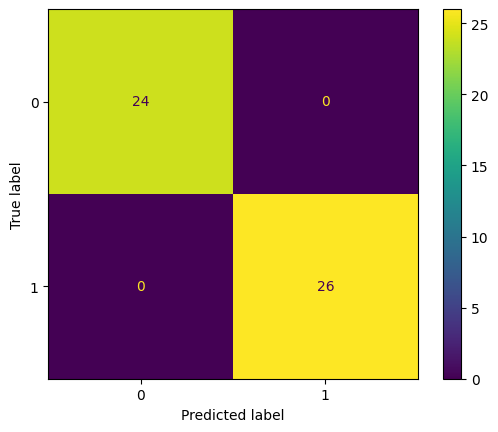

In [37]:
disp.plot()

All of the very positive and very negative labels has been classified correctly! So our model did great job.